In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from cebmf_torch import cEBMF
# Reproducibility
torch.manual_seed(1)

# -------------------------
# 1) Random uniform data
# -------------------------
N = 2000  
P=1000
 

ADD spatial effect

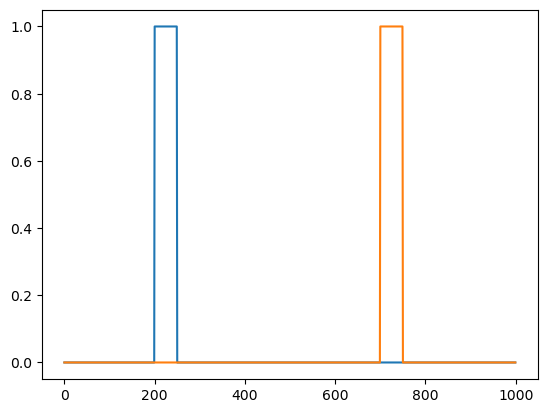

In [2]:
f1= torch.zeros(P)
f1[200:250]=1
f2= torch.zeros(P)
f2[700:750]=1


plt.plot(f1)
plt.plot(f2)

L1=   torch.randint(0, 2, (N,), dtype=torch.float32) 

L2=   torch.randint(0, 2, (N,), dtype=torch.float32) 
F_ATAC= torch.vstack([f1, f2 ] )
L_ATAC= torch.vstack([L1, L2 ] ).T
X_ATAC= L_ATAC @F_ATAC 

<Axes: >

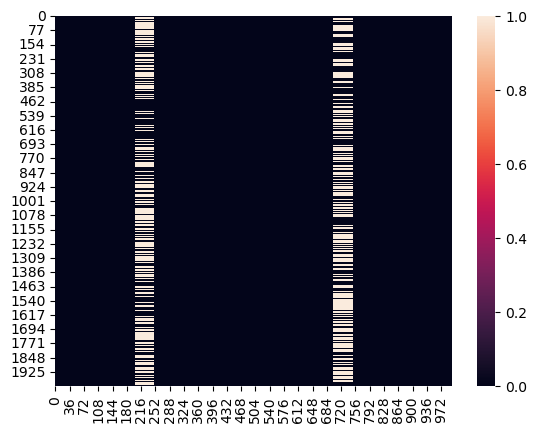

In [3]:
sns.heatmap(X_ATAC)

In [4]:
f1r= torch.zeros(P)
f1r[200:250]=1
f1r[500:250]=1
f1r[700:250]=1

f2r= torch.zeros(P)
 
f2r[500:550]=1
f2r[700:750]=1

f3r= torch.zeros(P)
 
f3r[200:250]=1
f3r[700:750]=1

f4r= torch.zeros(P)
f1r[200:250]=1
f1r[500:250]=1
 

L_RNA=L = torch.zeros(N, 4)

In [5]:
for i in range (L_RNA.shape[1]):
    if L_ATAC[i,1]==1 and L_ATAC[i,0]==0:
        L_RNA[i,0]=1

    if L_ATAC[i,0]==0 and L_ATAC[i,1]==1:
        L_RNA[i,1]=1

    if L_ATAC[i,0]==1 and L_ATAC[i,1]==1:
        L_RNA[i,2]=1

    if L_ATAC[i,0]==0 and L_ATAC[i,1]==0:
        L_RNA[i,3]=1


In [6]:
torch.sum(L_RNA[:,1])

tensor(1.)

In [7]:
# --- feature patterns (fix empty slices and wrong target) ---
f1r = torch.zeros(P); f1r[200:250] = 1; f1r[500:550] = 1; f1r[700:750] = 1
f2r = torch.zeros(P); f2r[500:550] = 1; f2r[700:750] = 1
f3r = torch.zeros(P); f3r[200:250] = 1; f3r[700:750] = 1
f4r = torch.zeros(P); f4r[200:250] = 1; f4r[500:550] = 1  # <-- was writing into f1r by mistake

# --- build L_RNA from L_ATAC patterns (no Python loop) ---
L_RNA = torch.zeros(N, 4, dtype=torch.float32, device=L_ATAC.device)

mask01 = (L_ATAC[:,0] == 0) & (L_ATAC[:,1] == 1)  # -> col 0
mask10 = (L_ATAC[:,0] == 1) & (L_ATAC[:,1] == 0)  # -> col 1  (FIXED)
mask11 = (L_ATAC[:,0] == 1) & (L_ATAC[:,1] == 1)  # -> col 2
mask00 = (L_ATAC[:,0] == 0) & (L_ATAC[:,1] == 0)  # -> col 3

L_RNA[mask01, 0] = 1
L_RNA[mask10, 1] = 1
L_RNA[mask11, 2] = 1
L_RNA[mask00, 3] = 1

print(L_RNA[:,1].sum())  # should now be equal to mask10.sum()


tensor(494.)


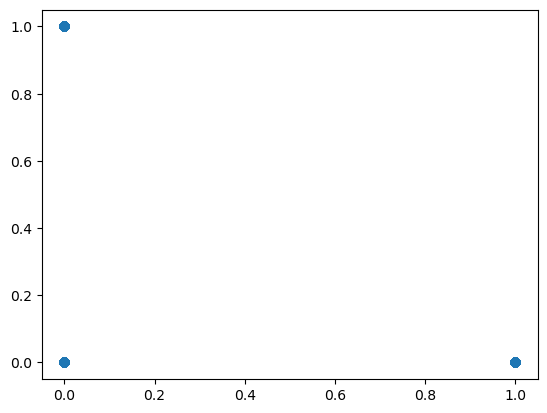

In [8]:
plt.scatter ( L_ATAC[:,1], L_RNA[:,1]) 

<Axes: >

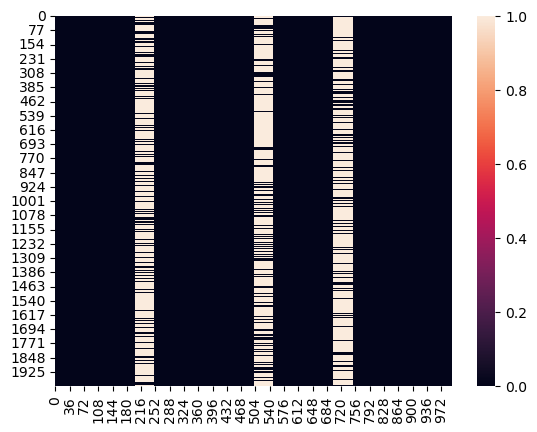

In [9]:
f_RNA =torch.vstack([f1r,f2r,f3r,f4r])

X_RNA= L_RNA @f_RNA

sns.heatmap(X_RNA)

In [ ]:

X_obs_RNA= X_RNA+2*torch.randn(N, P)

X_obs_ATAC= X_ATAC+2*torch.randn(N, P)

mycebmf0R=  cEBMF(data=X_obs_RNA ,K=10 ) 
mycebmf0R.initialize()

mycebmf0R.fit(50)


10
10
10
10
10
10
10
10
10
10
10
10
10
10
10


KeyboardInterrupt: 

In [14]:
mycebmf0A=  cEBMF(data=X_obs_ATAC ,K=10 ) 
mycebmf0A.initialize()

mycebmf0A.fit(50)

10
10


KeyboardInterrupt: 

<Axes: >

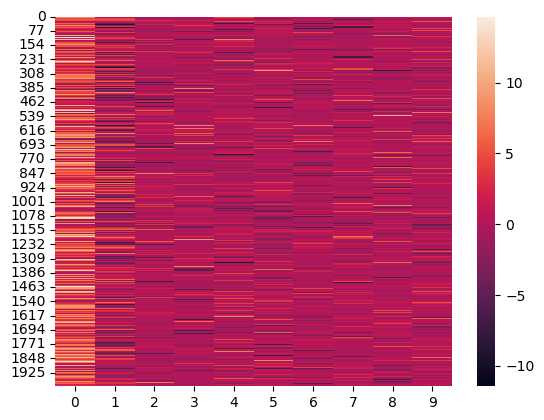

In [15]:
sns.heatmap(mycebmf0A.L)

<Axes: >

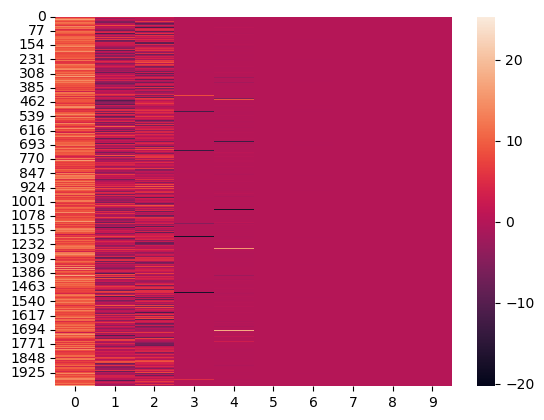

In [16]:

sns.heatmap(mycebmf0R.L)


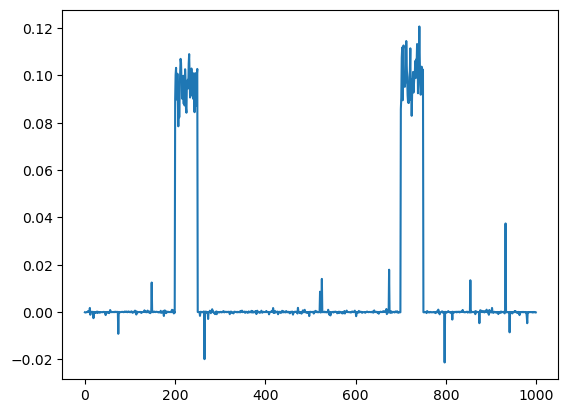

In [17]:
plt.plot(mycebmf0A.F[:,0])

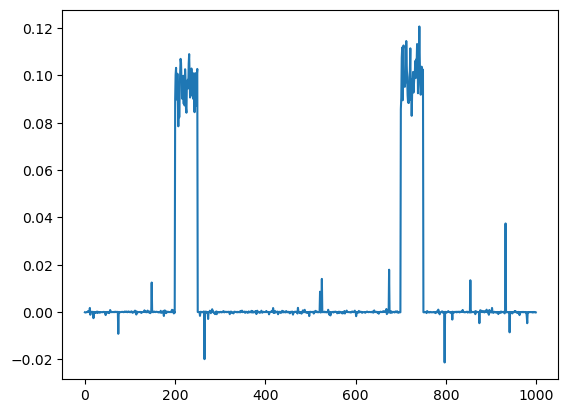

In [18]:
plt.plot(mycebmf0A.F[:,0])

In [19]:
X_initRNA  = mycebmf0A.L
X_initATAC = mycebmf0R.L
p_rna = X_obs_RNA.shape[1]                 # number of columns
y_rna =  torch.arange(1, p_rna + 1)
p_atac = X_obs_ATAC.shape[1]                 # number of columns
y_atac=  torch.arange(1,p_atac  + 1)  # 1 to p inclusive
 

In [21]:





mycebmfR=  cEBMF(data=X_obs_RNA,
                prior_L = "cgb",
                X_l= mycebmf0A.L,
                 prior_F="emdn", 
                  X_f=y_rna,
                   K=10 ,
                  allow_backfitting=False) 
mycebmfR.initialize()
mycebmfR.L=mycebmf0R.L
mycebmfR.F=mycebmf0R.F
mycebmfA=  cEBMF(data=X_obs_ATAC , 
                 prior_L = "cgb",
                X_l= mycebmf0A.L,
                  prior_F="emdn", 
                   X_f=y_rna,
                   K=10,
                  allow_backfitting=False ) 
mycebmfA.initialize()
mycebmfA.L=mycebmf0A.L
mycebmfA.F=mycebmf0A.F

In [22]:

for i in range(10):
    mycebmfR.X_l= mycebmfA.L
    mycebmfR.iter_once()
    mycebmfA.X_l= mycebmfR.L
    mycebmfA.iter_once()

[CGB] Epoch 10/50, Loss=5.0303, mu2=0.160, sigma2=8.933
[CGB] Epoch 20/50, Loss=5.0123, mu2=0.322, sigma2=8.586
[CGB] Epoch 30/50, Loss=4.9955, mu2=0.484, sigma2=8.874
[CGB] Epoch 40/50, Loss=4.9719, mu2=0.648, sigma2=7.597
[CGB] Epoch 50/50, Loss=4.9555, mu2=0.813, sigma2=7.812
[EMDN] Epoch 10/50, Loss: 0.6558
[EMDN] Epoch 20/50, Loss: -1.9296
[EMDN] Epoch 30/50, Loss: -2.1385
[EMDN] Epoch 40/50, Loss: -2.4100
[EMDN] Epoch 50/50, Loss: -1.6074
[CGB] Epoch 10/50, Loss=2.7761, mu2=-0.019, sigma2=4.713
[CGB] Epoch 20/50, Loss=2.7565, mu2=-0.094, sigma2=4.768
[CGB] Epoch 30/50, Loss=2.7479, mu2=-0.199, sigma2=5.075
[CGB] Epoch 40/50, Loss=2.7349, mu2=-0.322, sigma2=4.792
[CGB] Epoch 50/50, Loss=2.7247, mu2=-0.445, sigma2=4.106
[EMDN] Epoch 10/50, Loss: 0.6172
[EMDN] Epoch 20/50, Loss: -0.8486
[EMDN] Epoch 30/50, Loss: -1.8149
[EMDN] Epoch 40/50, Loss: -1.9155
[EMDN] Epoch 50/50, Loss: -1.9447
[CGB] Epoch 10/50, Loss=2.6615, mu2=0.001, sigma2=3.761


KeyboardInterrupt: 

In [ ]:
mycebmfA.L

tensor([[ 1.2330e+01, -2.5369e-01,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 9.6856e+00, -1.0236e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-3.4137e+00,  1.0882e-02,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 9.0037e+00,  1.9669e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-2.7626e+00, -2.1917e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-2.4207e+00, -1.2583e-02,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])

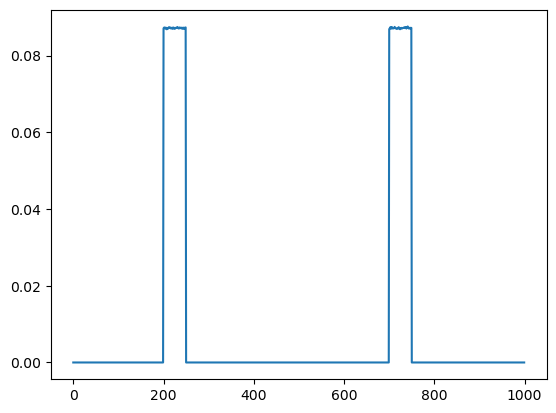

In [ ]:
plt.plot(mycebmfA.F[:,0
                    ])

<Axes: >

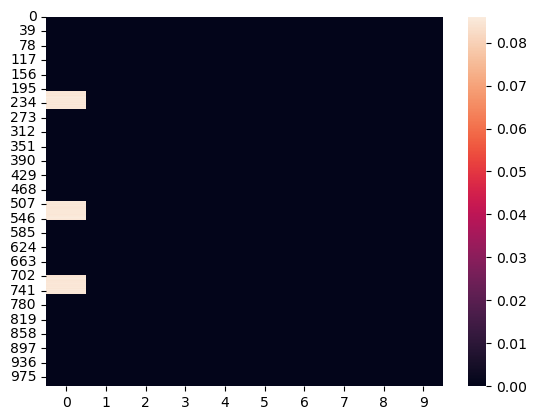

In [ ]:
sns.heatmap(mycebmfR.F)